In [ ]:
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, make_scorer

from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.svm import LinearSVC

from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier

from functools import reduce

import matplotlib.pyplot as plt

In [ ]:
#data = pd.read_json('../input/annamayya-song-lyrical-map/song_lyric_map.json')
data = pd.read_json('/content/drive/MyDrive/annamayya_dataset_cleaned.json')
# Labels
lbls = ['Devotional','Romantic']

In [ ]:
RAND_STATE = 42
TEST_SIZE = 0.3
WORD_CNT_THRESH = 10
CV_LEVELS = [5]

In [ ]:
freq = pd.Series(' '.join(data['Lyric']).split()).value_counts()
def filter_low_freq_words(s,f):
    return ' '.join([x for x in s.split() if f[x]>WORD_CNT_THRESH])
data.Lyric = data.Lyric.apply(lambda x:filter_low_freq_words(x,freq))

In [ ]:
X, X_test, y, y_test = train_test_split(data['Lyric'], data['genre'], test_size=0.1)

In [ ]:
count_vector = CountVectorizer()
X_counts = count_vector.fit_transform(X)
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)

In [ ]:
def do_grid_search(_X,_y,mdl,params,scoring,key,n=5):
    est = GridSearchCV(mdl,params,scoring=scoring,cv=n,return_train_score=True,refit=key,n_jobs=-1)
    est.fit(_X,_y)
    return est

In [ ]:
def plot_grid_results(est,keys,title):
    plt.figure(figsize=[12,3])
    plt.suptitle(title)
    for i,k in enumerate(keys):
        train_score = reduce(lambda a,b: list(a) + list(b), [est.cv_results_[f'split{x}_train_{k}'] for x in range(est.cv)])
        val_score = reduce(lambda a,b: list(a) + list(b), [est.cv_results_[f'split{x}_test_{k}'] for x in range(est.cv)])
        plt.subplot(1,len(keys),i+1)
        plt.plot(train_score)
        plt.plot(val_score)
        plt.legend(['Train','Validation'])
        plt.ylim([0,1.1])
        plt.grid()
        plt.title(k)
    plt.tight_layout()
    plt.show()

In [ ]:
scorers = {
    'Precision' : make_scorer(precision_score,pos_label=lbls[0]),
    'Recall' : make_scorer(recall_score,pos_label=lbls[0]),
    'F1_Score' : make_scorer(f1_score,pos_label=lbls[0]),
          }

In [ ]:
Models = {
    'Multi Nomial Naive Bayes Classification': (MultinomialNB(),{'alpha':[1e-3,1e-4,1e-5]}),
    'Bernoulli Naive Bayes Classification': (BernoulliNB(),{'alpha':[1e-3,1e-4,1e-5]}),
    'Complement Naive Bayes Classification': (ComplementNB(),{'alpha':[1e-3,1e-4,1e-5]}),
    'Logistic Regression' : (LogisticRegression(random_state=RAND_STATE),{'tol':[1e-3,1e-4,1e-5]}),
    'Nearest Centroid Classification': (NearestCentroid(),{}),
    'Ridge Classifier': (RidgeClassifier(random_state=RAND_STATE), {'alpha':[1e-3,1e-4,1e-5]}),
    'SGD Classifier': (SGDClassifier(random_state=RAND_STATE),{'alpha':[1e-3,1e-4,1e-5]}),
    'Linear SVC': (LinearSVC(random_state=RAND_STATE),{'tol':[1e-2,1e-4,1e-1]}),
    'Random Forest Classifier': (RandomForestClassifier(random_state=RAND_STATE),{'min_samples_leaf':[2,5,10]}),
    'XGB Classifier': (XGBClassifier(use_label_encoder=True),{'eta':[0.1,0.3,0.5],'objective':['binary:logistic']}),
}

In [ ]:
def run_nfold(n, Models):
    Res = {}
    for k in Models:
        print(f'Model {k}')
        Res[k] = do_grid_search(X_tfidf,y,Models[k][0],Models[k][1],scorers,'F1_Score',n)
        print('Best F1 Score : ' ,100*Res[k].best_score_, '%')
        plot_grid_results(Res[k],list(scorers.keys()),f'{n} Fold {k}')
    return Res

Model Multi Nomial Naive Bayes Classification
Best F1 Score :  67.14101153804893 %


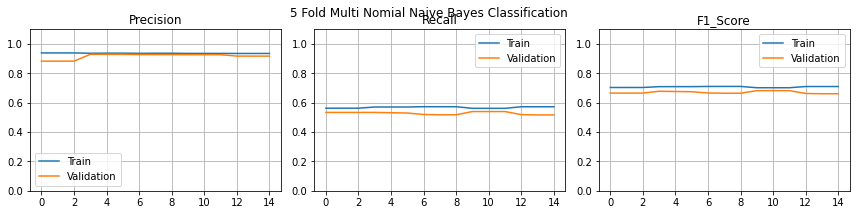

Model Bernoulli Naive Bayes Classification
Best F1 Score :  74.73623933823404 %


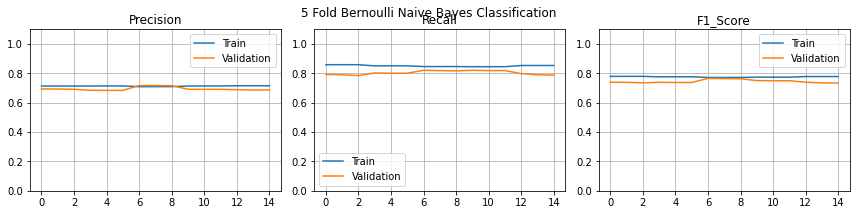

Model Complement Naive Bayes Classification
Best F1 Score :  75.22291628112468 %


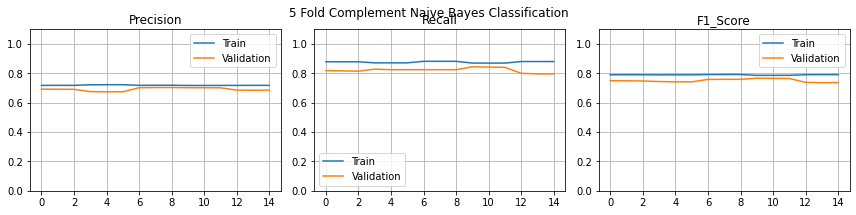

Model Logistic Regression
Best F1 Score :  71.56528726005564 %


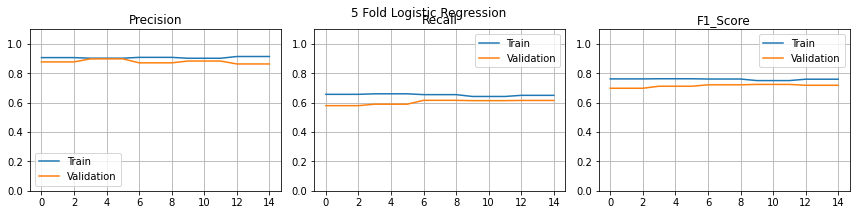

Model Nearest Centroid Classification
Best F1 Score :  68.35024347430043 %


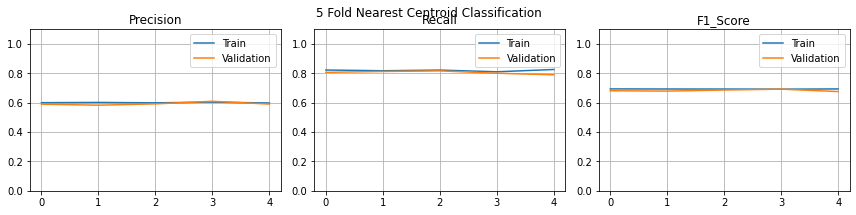

Model Ridge Classifier
Best F1 Score :  72.24672000302294 %


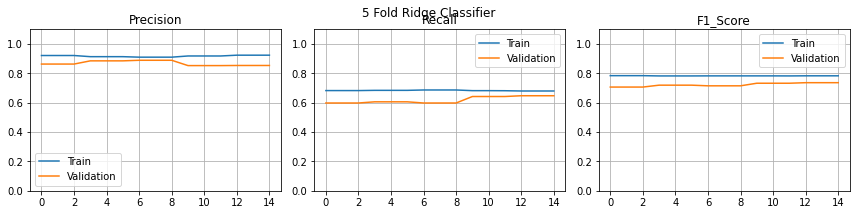

Model SGD Classifier
Best F1 Score :  74.74852104838877 %


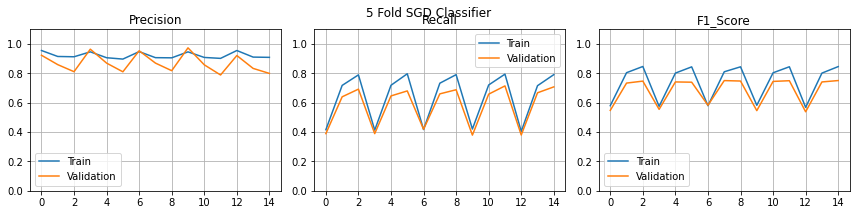

Model Linear SVC
Best F1 Score :  75.56055692356219 %


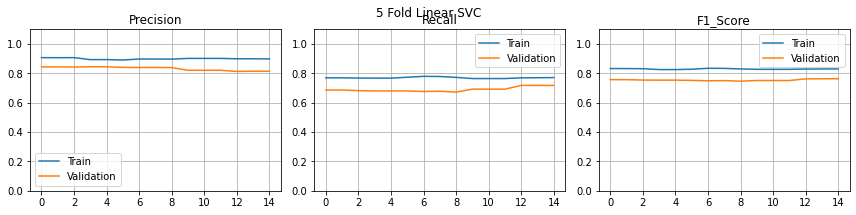

Model Random Forest Classifier
Best F1 Score :  64.94356875375809 %


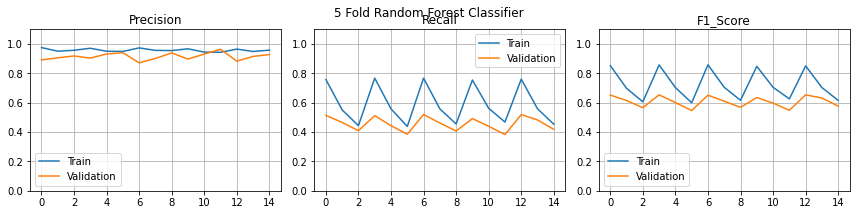

Model XGB Classifier
Best F1 Score :  57.210636190698935 %


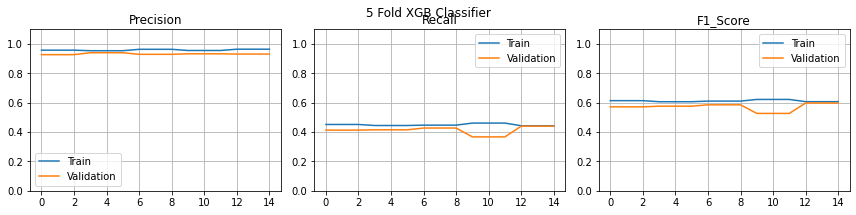

In [ ]:
Results = {}
Results['5Fold'] = run_nfold(5, Models)

In [ ]:
def convert_grid_search_to_df(nfold_result, name, X_test_tfidf, y_test):
    res = {'Model':[],
           f'{name} Test F1 Score':[],
           f'{name} Test Precision':[],
           f'{name} Test Recall':[],
           f'{name} Train F1 Score':[],
           f'{name} Train Precision':[],
           f'{name} Train Recall':[],
           f'{name} Validation Precision':[],
           f'{name} Validation F1 Score':[],
           f'{name} Validation Recall':[],
           'Best Parameters':[]}
    for k in Models:
        res['Model'].append(k)
        iii = nfold_result[k].best_index_
        res[f'{name} Test F1 Score'].append(f1_score(y_test, nfold_result[k].predict(X_test_tfidf),pos_label=lbls[0]))
        res[f'{name} Test Precision'].append(precision_score(y_test, nfold_result[k].predict(X_test_tfidf),pos_label=lbls[0]))
        res[f'{name} Test Recall'].append(recall_score(y_test, nfold_result[k].predict(X_test_tfidf),pos_label=lbls[0])) 
        res[f'{name} Train F1 Score'].append(nfold_result[k].cv_results_['mean_train_F1_Score'][iii])
        res[f'{name} Train Precision'].append(nfold_result[k].cv_results_['mean_train_Precision'][iii])
        res[f'{name} Train Recall'].append(nfold_result[k].cv_results_['mean_train_Recall'][iii])
        res[f'{name} Validation F1 Score'].append(nfold_result[k].cv_results_['mean_test_F1_Score'][iii])
        res[f'{name} Validation Precision'].append(nfold_result[k].cv_results_['mean_test_Precision'][iii])
        res[f'{name} Validation Recall'].append(nfold_result[k].cv_results_['mean_test_Recall'][iii])
        
        
        res['Best Parameters'].append(nfold_result[k].best_params_)
    df = pd.DataFrame(data=res)
    df.sort_values(by=f'{name} Test F1 Score', ascending=False, inplace=True)
    return df

In [ ]:
fold_5 = convert_grid_search_to_df(Results['5Fold'], '5 Fold', tfidf_transformer.transform(count_vector.transform(X_test)), y_test)

In [ ]:
fold_5

,Model,5 Fold Test F1 Score,5 Fold Test Precision,5 Fold Test Recall,5 Fold Train F1 Score,5 Fold Train Precision,5 Fold Train Recall,5 Fold Validation Precision,5 Fold Validation F1 Score,5 Fold Validation Recall,Best Parameters
1,Bernoulli Naive Bayes Classification,0.798107,0.773700,0.824104,0.776419,0.713552,0.851446,0.695592,0.747362,0.807550,{'alpha': 0.001}
6,SGD Classifier,0.785965,0.851711,0.729642,0.845778,0.905878,0.793190,0.806148,0.747485,0.697072,{'alpha': 1e-05}
7,Linear SVC,0.783688,0.859922,0.719870,0.830326,0.900272,0.770490,0.833425,0.755606,0.691453,{'tol': 0.0001}
2,Complement Naive Bayes Classification,0.783259,0.723757,0.853420,0.790257,0.719105,0.877059,0.692050,0.752229,0.824016,{'alpha': 0.001}
3,Logistic Regression,0.737452,0.905213,0.622150,0.759944,0.907918,0.653476,0.879692,0.715653,0.603460,{'tol': 0.001}
5,Ridge Classifier,0.733840,0.881279,0.628664,0.783581,0.918024,0.683508,0.869279,0.722467,0.618734,{'alpha': 0.001}
4,Nearest Centroid Classification,0.710227,0.629723,0.814332,0.693788,0.601051,0.820409,0.593476,0.683502,0.805940,{}
0,Multi Nomial Naive Bayes Classification,0.666667,0.946108,0.514658,0.707628,0.937238,0.568401,0.917568,0.671410,0.529526,{'alpha': 0.001}
8,Random Forest Classifier,0.628205,0.913043,0.478827,0.853904,0.970958,0.762053,0.889859,0.649436,0.511453,{'min_samples_leaf': 2}
9,XGB Classifier,0.546296,0.944000,0.384365,0.612568,0.959763,0.449880,0.932911,0.572106,0.413028,"{'eta': 0.1, 'objective': 'binary:logistic'}"


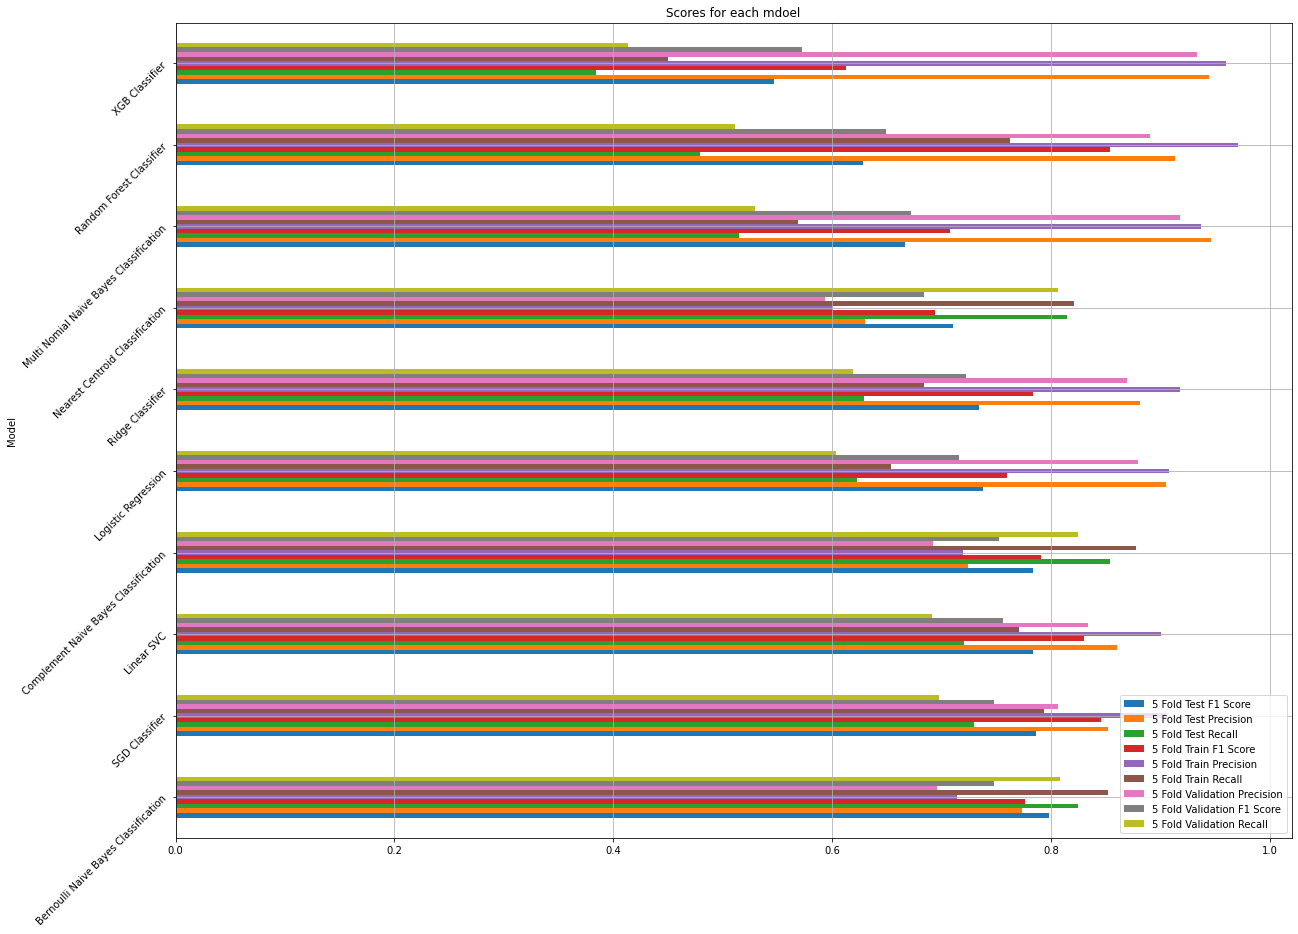

In [ ]:
fold_5.index = fold_5['Model']
f = fold_5.plot.barh(grid=True)
f.figure.set_size_inches([20,15])
plt.yticks(rotation=45)
plt.title('Scores for each mdoel')
plt.show()